In [4]:
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import time
import os
from IPython import display

In [32]:
from google.colab import drive
drive.mount('/content/drive')
train_x = loadmat('/content/drive/MyDrive/AML - john & samory/train_32x32.mat')['X']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
train_x.shape

(32, 32, 3, 73257)

In [34]:
#We need to get the number of images as the first dimension
train_x=train_x.transpose((3,0,1,2))
train_x.shape

(73257, 32, 32, 3)

In [35]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16

In [36]:
# from github - removed if else statement since we have all 32X32 images (made another function later for else part)
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        ax.imshow(img[i])


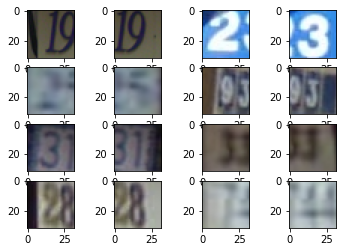

In [37]:
plot_images(train_x, 4, 4)

To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process.

Y = 0.2990R + 0.5870G + 0.1140B

Here is a simple function that helps us print the size of a numpy array in a human readable format.

In [38]:
# # # from github
# def rgb2gray(images):
#     return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [39]:
# train_y = rgb2gray(train_x).astype(np.float32)
# test_x = rgb2gray(test_x).astype(np.float32)

In [44]:
#for greyscale- use below code
train_x = tf.image.rgb_to_grayscale(tf.convert_to_tensor(train_x)).numpy().astype(np.float32)

In [42]:
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        ax.imshow(img[i,:,:,0])

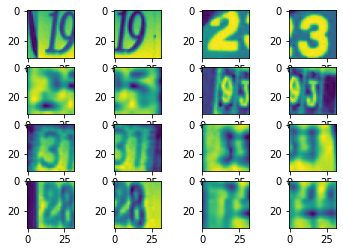

In [43]:
plot_images(train_y, 4, 4)

In [45]:
train_x = (train_x - 127.5) / 127.5 
#test_x = (test_x - 127.5) / 127.5

In [46]:
train_x = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#test_x = tf.data.Dataset.from_tensor_slices(test_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model_0():
  """
  Using DNN to generate images
  Input: random vector, shape = (100,)
  Output: image matrix, shape = (None,32,32,1), range = [-1, 1]
  """
  model = tf.keras.Sequential()
  model.add(layers.Dense(256, input_shape=(100,)))
  model.add(layers.Activation('relu'))

  model.add(layers.Dense(1024))
  model.add(layers.Activation('tanh'))

  model.add(layers.Reshape((32, 32, 1)))
  assert model.output_shape == (None, 32, 32, 1)

  return model

In [ ]:
def make_discriminator_model_0():
  """
  Input: image matrix, shape = (32,32,1)
  Output: softmax indicating True/False
  """
  model = tf.keras.Sequential()

  model.add(layers.Flatten())

  model.add(layers.Dense(256, activation='relu'))

  model.add(layers.Dense(1, activation = 'sigmoid'))

  return model

In [ ]:
generator_0,discriminator_0 = make_generator_model_0(),make_discriminator_model_0()


In [ ]:
# from tutorial
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# from tutorial
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# from tutorial
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# from tutorial (made some changes)
def train(dataset, epochs, generator, discriminator):

  for epoch in range(epochs):
    start = time.time()

    # train
    loss_train = []
    for image_batch in dataset:
      loss_train.append(train_step(image_batch, generator, discriminator))

    train_loss.loc[len(train_loss)] = np.mean(loss_train, axis=0)

    # tensorboard
    with gen_summary_writer.as_default():
        tf.summary.scalar('generaotr_loss', train_loss.gen_loss.values[-1], step=epoch)
    with disc_summary_writer.as_default():
        tf.summary.scalar('discrinimator_loss', train_loss.disc_loss.values[-1], step=epoch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    print('Time for epoch {} is {} sec, generation loss: {}, discrimination loss: {}'.format(epoch + 1, time.time()-start, train_loss.gen_loss.values[-1], train_loss.disc_loss.values[-1]))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  return 
  



In [ ]:
# from github - added function
def summary_writer(dir):
    return(tf.summary.create_file_writer(dir))
gen_log_dir = 'logs/gradient_tape/GAN_gen'
disc_log_dir = 'logs/gradient_tape/GAN_disc'
gen_summary_writer = summary_writer(gen_log_dir)
disc_summary_writer = summary_writer(disc_log_dir)

In [ ]:
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

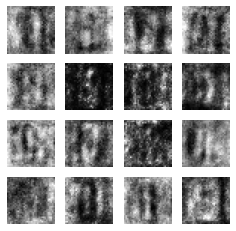

In [ ]:
train(train_x, 3000, generator_0, discriminator_0)

In [ ]:
def make_generator_model_1():
  """
  Using CNN to generate images
  Input: random vector, shape = (100,)
  Output: image matrix, shape = (None,32,32,1)
  """
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  return model

In [ ]:
def make_discriminator_model_1():
  """
  Input: image matrix, shape = (32,32,1)
  Output: softmax indicating True/False
  """

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[32, 32, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.add(layers.Activation('sigmoid'))

  return model

In [ ]:
generator_1 = make_generator_model_1()
discriminator_1 = make_discriminator_model_1()

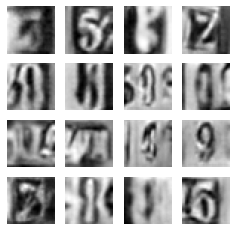

In [ ]:
tf.config.run_functions_eagerly(True)
train(train_x, 500, generator_1, discriminator_1)

In [ ]:
def make_generator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [ ]:
def make_discriminator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (7, 7), strides=(1, 1), padding='same',input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1))

    return model

In [ ]:
generator_2 = make_generator_model_2()
discriminator_2 = make_discriminator_model_2()

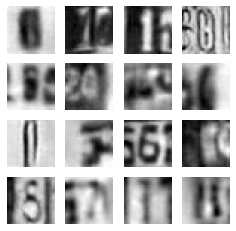

Time for epoch 239 is 37.12943148612976 sec, generation loss: 0.20252874493598938, discrimination loss: 7.1959919929504395


In [ ]:
tf.config.run_functions_eagerly(True)
train(train_x, 500, generator_2, discriminator_2)